# Options sur devises

In [35]:
# Some useful imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

## Simulation de trajectoires

In [36]:
def simulate(S0, sigma, r0, r1, N, T):
    S = np.zeros(N)
    dt = T/N
    S[0] = S0
    for i in range(1, N):
        Z = np.random.normal(0, 1)
        S[i] = S[i-1] + S[i-1] * (sigma * np.sqrt(dt) * Z + (r0-r1) * dt)
    return S

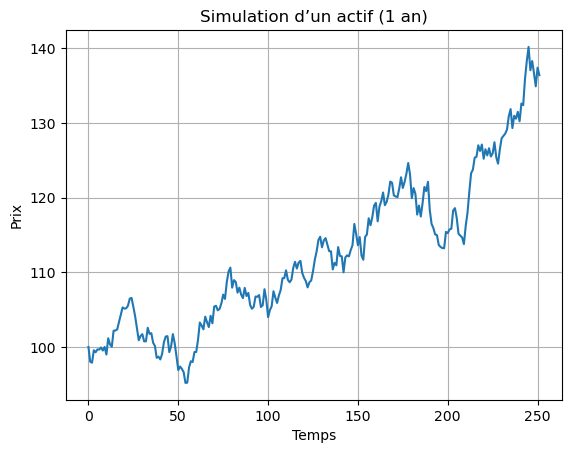

In [37]:
# Paramètres
S0 = 100
sigma = 0.2
r0 = 0.05
r1 = 0.02
N = 252
T = 1
K = 100  # Strike

# Simulation
S = simulate(S0, sigma, r0, r1, N, T)

# Affichage
plt.plot(S)
plt.title("Simulation d’un actif (1 an)")
plt.xlabel("Temps")
plt.ylabel("Prix")
plt.grid(True)
plt.show()

## Prix et Delta

In [38]:
def F(t, x, K, sigma, r0, r1, T):
    d1 = (np.log(x/K)+(r0-r1+(sigma**2/2)*(T-t)))/(sigma*np.sqrt(T-t))
    d2 = d1 - sigma*np.sqrt(T-t)
    return x*np.exp(-r1*(T-t))*norm.cdf(d1) - K*np.exp(-r0*(T-t))*norm.cdf(d2)

def delta(t, x, K, sigma, r0, r1, T):
    d = np.log(x * np.exp(-r1*(T-t)) / (K * np.exp(-r0*(T-t)))) / (sigma*np.sqrt(T-t))
    d += sigma*np.sqrt(T-t)/2
    return np.exp(-r1*(T-t)) * norm.cdf(d)

def hedging(S, N, T, K, sigma, r0, r1):
    H0 = np.zeros(N)
    H = np.zeros(N)
    for i in range(N):
        t = i*T/N
        H[i] = delta(t, S[i], K, sigma, r0, r1, T)
        H0[i] = F(t, S[i], K, sigma, r0, r1, T) - H[i]*S[i]
    return H0, H

def value(H0, H, S):
    return H0 + H * S

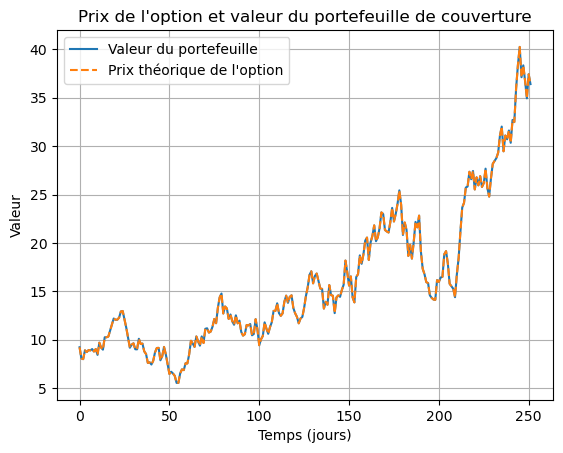

In [41]:
H0, H = hedging(S, N, T, K, sigma, r0, r1)
portfolio_value = value(H0, H, S)

# Valeur réelle de l’option à chaque date
F_real = np.array([F(i*T/N, S[i], K, sigma, r0, r1, T) for i in range(N)])

# Affichage
plt.plot(portfolio_value, label="Valeur du portefeuille")
plt.plot(F_real, linestyle='--', label="Prix théorique de l'option")
plt.title("Prix de l'option et valeur du portefeuille de couverture")
plt.xlabel("Temps (jours)")
plt.ylabel("Valeur")
plt.legend()
plt.grid(True)
plt.show()